In [50]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [51]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [52]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

# 데이터 전처리

UserId와 Time 정보를 가지고 Session 단위로 해석합니다.
* UserId 같으면서 시간이 10분 이내 간격인 것


#### TimeDiff 컬럼 생성

In [53]:
import datetime
import time 
data['Time'] = (data['Time']).apply(datetime.datetime.fromtimestamp)

In [54]:
data['TimeDiff'] = data['Time'].diff().abs()
data['TimeDiff']

31                    NaT
22        0 days 00:00:36
27        0 days 00:00:00
37        0 days 00:00:00
24        0 days 00:00:48
                ...      
1000019   0 days 00:00:31
999988    0 days 00:00:35
1000172   0 days 00:00:00
1000167   0 days 00:00:22
1000042   9 days 23:02:49
Name: TimeDiff, Length: 1000209, dtype: timedelta64[ns]

In [55]:
t = datetime.datetime.now()
data.loc[31, 'TimeDiff'] =t-t
data['TimeDiff']

31        0 days 00:00:00
22        0 days 00:00:36
27        0 days 00:00:00
37        0 days 00:00:00
24        0 days 00:00:48
                ...      
1000019   0 days 00:00:31
999988    0 days 00:00:35
1000172   0 days 00:00:00
1000167   0 days 00:00:22
1000042   9 days 23:02:49
Name: TimeDiff, Length: 1000209, dtype: timedelta64[ns]

In [56]:
td = datetime.timedelta(minutes=10)
data[data['TimeDiff']>td]

,UserId,ItemId,Rating,Time,TimeDiff
9,1,919,4,2000-12-31 22:22:48,0 days 00:10:08
28,1,1545,4,2001-01-06 23:35:39,6 days 00:57:38
130,2,1198,4,2000-12-31 21:28:44,6 days 02:10:27
217,3,593,3,2000-12-31 21:10:18,0 days 00:52:36
234,4,1210,3,2000-12-31 20:18:44,0 days 01:16:20
...,...,...,...,...,...
999907,6040,3095,4,2000-07-10 23:22:23,26 days 14:27:36
999979,6040,1900,5,2000-07-28 23:52:32,18 days 00:16:26
999975,6040,3182,5,2001-03-10 03:41:22,224 days 03:39:42
999984,6040,2575,4,2001-08-10 14:29:22,153 days 10:48:00


#### UserIdDiff 컬럼 생성

In [57]:
data['UserIdDiff'] = data['UserId'].diff().abs()
data['UserIdDiff'][31]=0
data['UserIdDiff']

31         0.0
22         0.0
27         0.0
37         0.0
24         0.0
          ... 
1000019    0.0
999988     0.0
1000172    0.0
1000167    0.0
1000042    0.0
Name: UserIdDiff, Length: 1000209, dtype: float64

#### Session이 달라지는 곳을 찾아내서 SessionChange 컬럼 생성

In [58]:
data[(data['UserIdDiff']!=0) | (data['TimeDiff'] > td)]

,UserId,ItemId,Rating,Time,TimeDiff,UserIdDiff
9,1,919,4,2000-12-31 22:22:48,0 days 00:10:08,0.0
28,1,1545,4,2001-01-06 23:35:39,6 days 00:57:38,0.0
130,2,1198,4,2000-12-31 21:28:44,6 days 02:10:27,1.0
217,3,593,3,2000-12-31 21:10:18,0 days 00:52:36,1.0
234,4,1210,3,2000-12-31 20:18:44,0 days 01:16:20,1.0
...,...,...,...,...,...,...
999907,6040,3095,4,2000-07-10 23:22:23,26 days 14:27:36,0.0
999979,6040,1900,5,2000-07-28 23:52:32,18 days 00:16:26,0.0
999975,6040,3182,5,2001-03-10 03:41:22,224 days 03:39:42,0.0
999984,6040,2575,4,2001-08-10 14:29:22,153 days 10:48:00,0.0


In [59]:
data['SessionChange'] = (data['UserIdDiff']!=0) | (data['TimeDiff'] > td)
data['SessionChange']

31         False
22         False
27         False
37         False
24         False
           ...  
1000019    False
999988     False
1000172    False
1000167    False
1000042     True
Name: SessionChange, Length: 1000209, dtype: bool

In [60]:
data['SessionChange'].value_counts()

False    971831
True      28378
Name: SessionChange, dtype: int64

#### SessionChange를 바탕으로 SessionId 생성

In [61]:
data['SessionId'] = data['SessionChange'].cumsum()
data['SessionId']

31             0
22             0
27             0
37             0
24             0
           ...  
1000019    28377
999988     28377
1000172    28377
1000167    28377
1000042    28378
Name: SessionId, Length: 1000209, dtype: int64

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype          
---  ------         --------------    -----          
 0   UserId         1000209 non-null  int32          
 1   ItemId         1000209 non-null  int32          
 2   Rating         1000209 non-null  int32          
 3   Time           1000209 non-null  datetime64[ns] 
 4   TimeDiff       1000209 non-null  timedelta64[ns]
 5   UserIdDiff     1000209 non-null  float64        
 6   SessionChange  1000209 non-null  bool           
 7   SessionId      1000209 non-null  int64          
dtypes: bool(1), datetime64[ns](1), float64(1), int32(3), int64(1), timedelta64[ns](1)
memory usage: 82.8 MB


In [63]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         12
1         28
2         13
3        129
4         51
        ... 
28374      7
28375     14
28376      1
28377     21
28378      1
Length: 28379, dtype: int64

In [64]:
session_length.median(), session_length.mean()

(6.0, 35.244687973501534)

In [65]:
session_length.min(), session_length.max()

(1, 1193)

In [66]:
session_length.quantile(0.999)

683.1100000000151

In [67]:
long_session = session_length[session_length==1193].index[0]
data[data['SessionId']==long_session].head(20)

,UserId,ItemId,Rating,Time,TimeDiff,UserIdDiff,SessionChange,SessionId
637775,3841,1480,3,2000-08-11 11:57:39,0 days 21:58:11,0.0,True,18614
637808,3841,969,5,2000-08-11 11:57:39,0 days 00:00:00,0.0,False,18614
638269,3841,858,5,2000-08-11 11:57:39,0 days 00:00:00,0.0,False,18614
638716,3841,2019,5,2000-08-11 11:57:39,0 days 00:00:00,0.0,False,18614
638733,3841,1221,5,2000-08-11 11:57:39,0 days 00:00:00,0.0,False,18614
637782,3841,2288,2,2000-08-11 11:58:36,0 days 00:00:57,0.0,False,18614
638122,3841,1304,5,2000-08-11 11:58:36,0 days 00:00:00,0.0,False,18614
638172,3841,1196,3,2000-08-11 11:58:36,0 days 00:00:00,0.0,False,18614
638266,3841,1387,5,2000-08-11 11:58:36,0 days 00:00:00,0.0,False,18614
638310,3841,2366,5,2000-08-11 11:58:36,0 days 00:00:00,0.0,False,18614


In [68]:
# 세션 길이 기준 하위 99.9%까지 분포 누적합 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.280101
2      0.383030
3      0.433701
4      0.467775
5      0.498467
         ...   
663    0.998802
670    0.998872
671    0.998908
674    0.998943
680    0.998978
Length: 507, dtype: float64

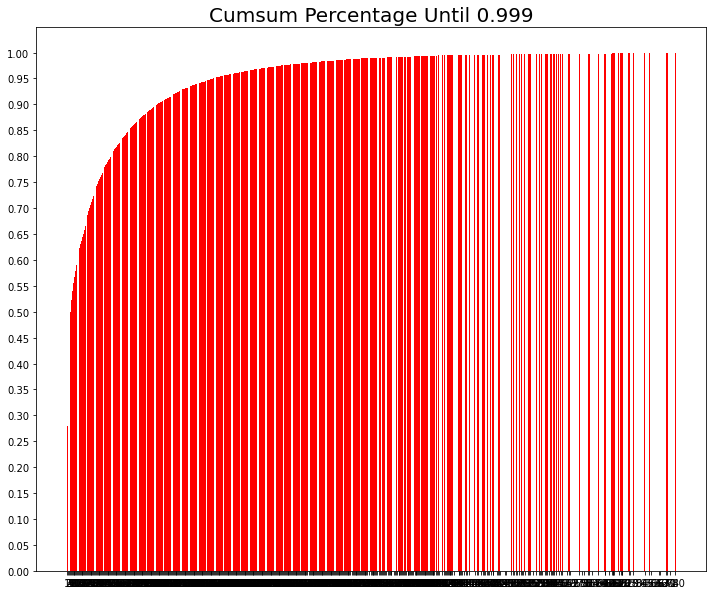

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [70]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [78]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click, least_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        data = cleanse_unfavorite_item(data, least_rating)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data


def cleanse_unfavorite_item(data: pd.DataFrame, least_rating):
    data = data.drop(data[data['Rating'] < least_rating].index)
    return data

In [79]:
data = cleanse_recursive(data, shortest=2, least_click=5, least_rating=3)
data

,UserId,ItemId,Rating,Time,TimeDiff,UserIdDiff,SessionChange,SessionId
31,1,3186,4,2000-12-31 22:00:19,0 days 00:00:00,0.0,False,0
22,1,1270,5,2000-12-31 22:00:55,0 days 00:00:36,0.0,False,0
27,1,1721,4,2000-12-31 22:00:55,0 days 00:00:00,0.0,False,0
37,1,1022,5,2000-12-31 22:00:55,0 days 00:00:00,0.0,False,0
24,1,2340,3,2000-12-31 22:01:43,0 days 00:00:48,0.0,False,0
...,...,...,...,...,...,...,...,...
999923,6040,232,5,2001-08-10 14:39:58,0 days 00:00:31,0.0,False,28377
1000019,6040,2917,4,2001-08-10 14:40:29,0 days 00:00:31,0.0,False,28377
999988,6040,1921,4,2001-08-10 14:41:04,0 days 00:00:35,0.0,False,28377
1000172,6040,1784,3,2001-08-10 14:41:04,0 days 00:00:00,0.0,False,28377


In [80]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

#### test 기간 60일, val 기간 60일로 설정

In [81]:
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=60)

In [82]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [83]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 823258
	 Sessions: 18958
	 Items: 3298
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-10-31 16:33:08

* valid Set Stats Info
	 Events: 2390
	 Sessions: 207
	 Items: 1246
	 First Time : 2002-11-01 02:56:19
	 Last Time : 2002-12-30 16:54:04

* test Set Stats Info
	 Events: 2452
	 Sessions: 217
	 Items: 1261
	 First Time : 2002-12-30 19:06:03
	 Last Time : 2003-02-28 17:49:50



In [84]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [85]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 미니 배치의 구성

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [86]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [87]:
tr_dataset = SessionDataset(tr)
tr_dataset.click_offsets

array([     0,     12,     40, ..., 823224, 823237, 823258], dtype=int32)

In [88]:
tr_dataset.click_offsets

array([     0,     12,     40, ..., 823224, 823237, 823258], dtype=int32)

In [89]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 18955, 18956, 18957])

In [90]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """
        #print(start)
        #print(end)
        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        length = len(self.dataset.session_idx)   
        first_iters = np.arange(min(self.batch_size, length))    # 첫 배치에 사용할 세션 Index를 가져옵니다. [0, 1 ,...1496 .2048]
        last_session = self.batch_size - 1  # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [91]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,TimeDiff,UserIdDiff,SessionChange,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,0 days 00:00:00,0.0,False,0,0
22,1,1270,5,2000-12-31 22:00:55,0 days 00:00:36,0.0,False,0,1
27,1,1721,4,2000-12-31 22:00:55,0 days 00:00:00,0.0,False,0,2
37,1,1022,5,2000-12-31 22:00:55,0 days 00:00:00,0.0,False,0,3
24,1,2340,3,2000-12-31 22:01:43,0 days 00:00:48,0.0,False,0,4
36,1,1836,5,2000-12-31 22:02:52,0 days 00:01:09,0.0,False,0,5
3,1,3408,4,2000-12-31 22:04:35,0 days 00:01:43,0.0,False,0,6
7,1,2804,5,2000-12-31 22:11:59,0 days 00:07:24,0.0,False,0,7
47,1,1207,4,2000-12-31 22:11:59,0 days 00:00:00,0.0,False,0,8
0,1,1193,5,2000-12-31 22:12:40,0 days 00:00:41,0.0,False,0,9


In [92]:
iter_ex = iter(tr_data_loader)

In [93]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 12 40 53]
Label Item Idx are :       [ 1 13 41 54]
Previous Masked Input Idx are []


# 모델 구성

In [94]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [95]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [96]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [97]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)

In [98]:
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3298)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      502500    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3298)                168198    
Total params: 670,698
Trainable params: 670,698
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [99]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [100]:
train_model(model, args)


Evaluation:  38%|███▊      | 13/34 [00:04<00:06,  3.23it/s]


	 - Recall@20 epoch 1: 0.150240
	 - MRR@20    epoch 1: 0.043101



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.36it/s]


	 - Recall@20 epoch 2: 0.147837
	 - MRR@20    epoch 2: 0.038556



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.42it/s]


	 - Recall@20 epoch 3: 0.159856
	 - MRR@20    epoch 3: 0.042988



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.43it/s]


	 - Recall@20 epoch 4: 0.156250
	 - MRR@20    epoch 4: 0.038660



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.49it/s]


	 - Recall@20 epoch 5: 0.147837
	 - MRR@20    epoch 5: 0.041128



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.42it/s]


	 - Recall@20 epoch 6: 0.149038
	 - MRR@20    epoch 6: 0.040815



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.40it/s]


	 - Recall@20 epoch 7: 0.165865
	 - MRR@20    epoch 7: 0.042443



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.41it/s]


	 - Recall@20 epoch 8: 0.146635
	 - MRR@20    epoch 8: 0.049630



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.46it/s]


	 - Recall@20 epoch 9: 0.155048
	 - MRR@20    epoch 9: 0.045952



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.49it/s]

	 - Recall@20 epoch 10: 0.145433
	 - MRR@20    epoch 10: 0.044262



# 모델 테스트

테스트셋을 바탕으로 Recall, MRR을 확인해 봅니다.

In [47]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")


In [101]:
test_model(model, args, test)

Evaluation:  35%|███▌      | 12/34 [00:03<00:06,  3.38it/s]

	 - Recall@20: 0.141927
	 - MRR@20: 0.049770



# 다른 configuration 으로 실험

#### 1: lr 변경


In [48]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3405)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      518550    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3405)                173655    
Total params: 692,205
Trainable params: 692,205
Non-trainable params: 0
_________________________________________________________________


Evaluation:  41%|████▏     | 17/41 [00:05<00:07,  3.06it/s]


	 - Recall@20 epoch 1: 0.146140
	 - MRR@20    epoch 1: 0.036000



Evaluation:  41%|████▏     | 17/41 [00:04<00:06,  3.49it/s]


	 - Recall@20 epoch 2: 0.159926
	 - MRR@20    epoch 2: 0.044669



Evaluation:  41%|████▏     | 17/41 [00:04<00:06,  3.51it/s]


	 - Recall@20 epoch 3: 0.170956
	 - MRR@20    epoch 3: 0.049213



Evaluation:  41%|████▏     | 17/41 [00:04<00:07,  3.42it/s]


	 - Recall@20 epoch 4: 0.181985
	 - MRR@20    epoch 4: 0.053476



Evaluation:  41%|████▏     | 17/41 [00:04<00:06,  3.51it/s]


	 - Recall@20 epoch 5: 0.179228
	 - MRR@20    epoch 5: 0.054348



Evaluation:  41%|████▏     | 17/41 [00:04<00:06,  3.53it/s]


	 - Recall@20 epoch 6: 0.178309
	 - MRR@20    epoch 6: 0.055293



Evaluation:  41%|████▏     | 17/41 [00:04<00:06,  3.52it/s]


	 - Recall@20 epoch 7: 0.181066
	 - MRR@20    epoch 7: 0.055595



Evaluation:  41%|████▏     | 17/41 [00:04<00:06,  3.52it/s]


	 - Recall@20 epoch 8: 0.181066
	 - MRR@20    epoch 8: 0.055406



Evaluation:  41%|████▏     | 17/41 [00:04<00:06,  3.58it/s]


	 - Recall@20 epoch 9: 0.182904
	 - MRR@20    epoch 9: 0.056307



Evaluation:  41%|████▏     | 17/41 [00:04<00:06,  3.55it/s]

	 - Recall@20 epoch 10: 0.179228
	 - MRR@20    epoch 10: 0.055764



In [49]:
test_model(model, args, test)

Evaluation:  36%|███▋      | 16/44 [00:04<00:07,  3.53it/s]

	 - Recall@20: 0.187500
	 - MRR@20: 0.078623



#### 2. batchsize 변경


In [104]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 1, 3298)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    502500    
_________________________________________________________________
dropout_6 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_6 (Dense)              (128, 3298)               168198    
Total params: 670,698
Trainable params: 670,698
Non-trainable params: 0
_________________________________________________________________


Evaluation:  18%|█▊        | 3/17 [00:01<00:08,  1.59it/s]


	 - Recall@20 epoch 1: 0.080729
	 - MRR@20    epoch 1: 0.023771



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.76it/s]


	 - Recall@20 epoch 2: 0.098958
	 - MRR@20    epoch 2: 0.031778



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.75it/s]


	 - Recall@20 epoch 3: 0.122396
	 - MRR@20    epoch 3: 0.034865



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.78it/s]


	 - Recall@20 epoch 4: 0.122396
	 - MRR@20    epoch 4: 0.037610



Evaluation:  18%|█▊        | 3/17 [00:01<00:08,  1.75it/s]


	 - Recall@20 epoch 5: 0.127604
	 - MRR@20    epoch 5: 0.038713



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.78it/s]


	 - Recall@20 epoch 6: 0.122396
	 - MRR@20    epoch 6: 0.038815



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.82it/s]


	 - Recall@20 epoch 7: 0.130208
	 - MRR@20    epoch 7: 0.039471



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.82it/s]


	 - Recall@20 epoch 8: 0.138021
	 - MRR@20    epoch 8: 0.043367



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.75it/s]


	 - Recall@20 epoch 9: 0.135417
	 - MRR@20    epoch 9: 0.040130



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.83it/s]


	 - Recall@20 epoch 10: 0.138021
	 - MRR@20    epoch 10: 0.042461



Evaluation:  18%|█▊        | 3/17 [00:01<00:07,  1.81it/s]

	 - Recall@20: 0.127604
	 - MRR@20: 0.041113



#### 3. hidden size 변경


In [105]:
args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(64, 1, 3298)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1020000   
_________________________________________________________________
dropout_7 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_7 (Dense)              (64, 3298)                333098    
Total params: 1,353,098
Trainable params: 1,353,098
Non-trainable params: 0
_________________________________________________________________


Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.31it/s]


	 - Recall@20 epoch 1: 0.138221
	 - MRR@20    epoch 1: 0.041383



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.44it/s]


	 - Recall@20 epoch 2: 0.163462
	 - MRR@20    epoch 2: 0.046874



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.40it/s]


	 - Recall@20 epoch 3: 0.167067
	 - MRR@20    epoch 3: 0.046685



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.46it/s]


	 - Recall@20 epoch 4: 0.174279
	 - MRR@20    epoch 4: 0.047850



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.43it/s]


	 - Recall@20 epoch 5: 0.170673
	 - MRR@20    epoch 5: 0.046525



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.41it/s]


	 - Recall@20 epoch 6: 0.177885
	 - MRR@20    epoch 6: 0.047532



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.47it/s]


	 - Recall@20 epoch 7: 0.170673
	 - MRR@20    epoch 7: 0.047985



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.48it/s]


	 - Recall@20 epoch 8: 0.162260
	 - MRR@20    epoch 8: 0.047887



Evaluation:  38%|███▊      | 13/34 [00:03<00:05,  3.54it/s]


	 - Recall@20 epoch 9: 0.162260
	 - MRR@20    epoch 9: 0.049167



Evaluation:  38%|███▊      | 13/34 [00:03<00:06,  3.46it/s]


	 - Recall@20 epoch 10: 0.164663
	 - MRR@20    epoch 10: 0.049234



Evaluation:  35%|███▌      | 12/34 [00:03<00:06,  3.59it/s]

	 - Recall@20: 0.186198
	 - MRR@20: 0.066813



lr 변경, batchsize 변경, hidden size 변경을 실험했습니다.    
모두 5 epoch까지는 안정적으로 트레이닝 되었습니다. 그 이후에는 train set과 val set 둘다에서 성능이 유지되었습니다.   
lr을 0.001로, batchsize=hidden size를 50에서 100으로 변경한 모델이 가장 성능이 좋게 나왔습니다.   

# 회고

UserId와 타임스탬프로부터 SessionId를 도출해내는 부분을 즐겁게 했습니다.
Recall과 MRR이 높아지도록 트레이닝이 잘 안되는데, k보다 길이가 긴 세션들이 많아서 그럴것이라고 생각이 듭니다.  
추천시스템 exploration 중에서 가장 이해를 하면서 수행한 노드 같습니다.
mini-batch 중에서 한 아이템이 끝나면 다른 하나를 불러오는 방법은 코드를 더 이해해야되겠습니다.